# Using scMODAL to integrate the CITE-seq and CyTOF BMC datasets

In this tutorial, we apply scMODAL to integrate two human bone marrow single-cell proteomic datasets produced by CITE-seq and CyTOF. The raw datasets are available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE128639 and https://github.com/lmweber/benchmark-data-Levine-32-dim. Preprocessed data can be found here: https://drive.google.com/drive/folders/1Rv7lybglA1LDtyK6Og0myUaMTJI4PXnv?usp=sharing.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import os

import scmodal

import warnings
warnings.filterwarnings("ignore")

In [2]:
adata1 = sc.read_h5ad('./data/bone_marrow/citeseq_bm.h5ad')
adata2 = sc.read_h5ad('./data/bone_marrow/cytof_bm.h5ad')

In [3]:
shared_features = list(sorted(set(adata1.var.index & adata2.var.index)))

adata1_unq_genes = adata1.var.index.difference(shared_features)
adata2_unq_genes = adata2.var.index.difference(shared_features)
adata1 = adata1[:, list(shared_features) + list(adata1_unq_genes)]
adata2 = adata2[:, list(shared_features) + list(adata2_unq_genes)]
target_sum = np.median((np.exp(adata2.X)-1).sum(axis=1))
sc.pp.normalize_total(adata1, target_sum=target_sum)
sc.pp.log1p(adata1)

sc.pp.scale(adata1, max_value=10)
sc.pp.scale(adata2, max_value=10)

In [4]:
model = scmodal.model.Model(training_steps=10000, model_path="./BMC_protein")
model.preprocess(adata1, adata2, shared_gene_num=len(shared_features))

In [5]:
model.train()
model.eval()

Begining time:  Tue Oct  1 15:48:48 2024
step 0, loss_D=0.120380, loss_GAN=-0.071872, loss_AE=28.575163, loss_Geo=-19.302174, loss_LA=29.551353, loss_MNN=1.662618
step 2000, loss_D=1.162818, loss_GAN=-1.125175, loss_AE=0.908587, loss_Geo=-19.441975, loss_LA=0.179746, loss_MNN=0.239771
step 4000, loss_D=1.153088, loss_GAN=-1.126287, loss_AE=0.720650, loss_Geo=-19.455326, loss_LA=0.103125, loss_MNN=0.193310
step 6000, loss_D=1.086485, loss_GAN=-1.064310, loss_AE=0.740923, loss_Geo=-19.460247, loss_LA=0.106351, loss_MNN=0.178606
step 8000, loss_D=1.238451, loss_GAN=-1.219274, loss_AE=0.642324, loss_Geo=-19.462091, loss_LA=0.094618, loss_MNN=0.160187
Ending time:  Tue Oct  1 15:58:08 2024
Training takes 560.10 seconds
Begining time:  Tue Oct  1 15:58:08 2024
Ending time:  Tue Oct  1 15:58:08 2024
Evaluating takes 0.01 seconds


In [6]:
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata1.obs, adata2.obs])
adata_integrated.obs['modality'] = ['CITE-seq'] * adata1.shape[0] + ['CyTOF'] * adata2.shape[0]

scmodal.utils.compute_umap(adata_integrated)

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation', min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1, verbose=True)
Tue Oct  1 15:59:26 2024 Construct fuzzy simplicial set
Tue Oct  1 15:59:26 2024 Finding Nearest Neighbors
Tue Oct  1 15:59:26 2024 Building RP forest with 23 trees
Tue Oct  1 15:59:29 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Tue Oct  1 15:59:54 2024 Finished Nearest Neighbor Search
Tue Oct  1 15:59:57 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Oct  1 16:02:38 2024 Finished embedding


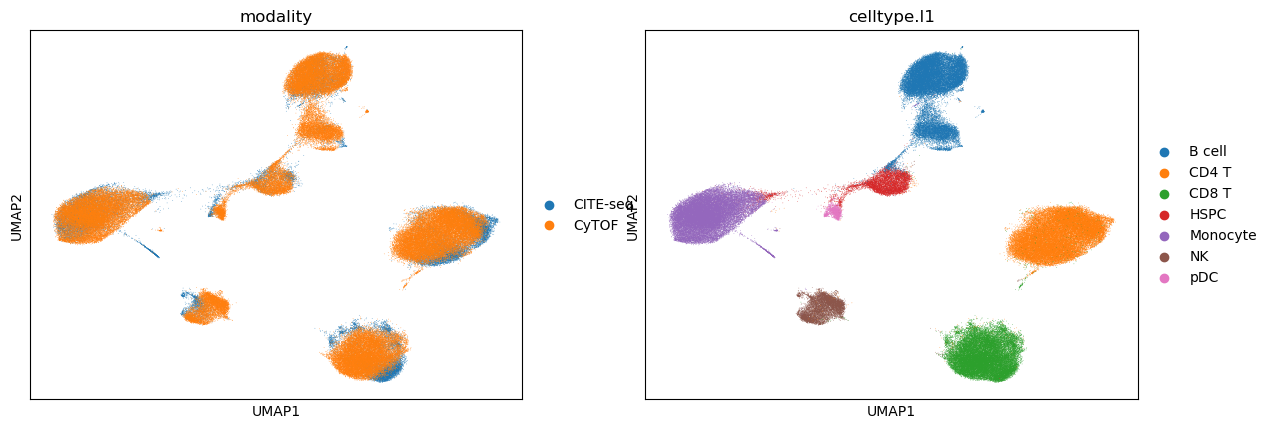

In [9]:
sc.pl.umap(adata_integrated, color=['modality', 'celltype.l1'])